In [1]:

import pickle
import time
import logging
import numpy as np
import extra_data as ed
from copy import copy
import os
from scipy import optimize
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.optimize import least_squares
from scipy.optimize import curve_fit


import cv2

import matplotlib.pyplot as plt
from skimage import transform

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
plt.rcParams['text.usetex'] = True

%config InlineBackend.figure_format='retina'

In [6]:
def extraVISARImages_mean(exp_id, run_id):
    # exp_id = 900352  # Commisioning experiment
    # run_id = 184  # Streak camera calibration image run

    # Import run data and display info on run
    run = ed.open_run(exp_id, run_id)
    # run.info()
    # Determine first and last train ids
    first_train = run.train_ids[0]
    last_train = run.train_ids[-1]
    # print(f"First train ID: {first_train}")
    # print(f"Last train ID: {last_train}")

    # Create a mask for pandas df where no data exists
    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present:\n{indexes}")

    # # Select train ID for streak calibration
    # train_id = 1605832127
    # print(f'\nSelecting Train ID: {train_id}')

    # Raw data from streak camera image
    kep1 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )


    imgKEP1_r = np.mean(kep1[:, :, :], axis = 0)
    # Rotate image 90 degrees
    imgKEP1_r = cv2.rotate(imgKEP1_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    f = np.loadtxt('../DewarpingCalibrationFiles/VISAR_KEPLER1_10nsWindow_900499_run78_polynomial_16042025.cal', delimiter=',')
    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP1_r_dewarp = cv2.remap(
        imgKEP1_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    
    
    

    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present")


    kep2 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )

    imgKEP2_r = np.mean(kep2, axis = 0)
    imgKEP2_r = cv2.rotate(imgKEP2_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    
    f = np.loadtxt('../DewarpingCalibrationFiles/VISAR_KEPLER2_10nsWindow_900499_run78_polynomial_16042025.cal', delimiter=',')

    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP2_r_dewarp = cv2.remap(
        imgKEP2_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    
    return imgKEP1_r_dewarp, imgKEP2_r_dewarp

In [ ]:
proposalNumber = 7902
runNumber = 648

In [9]:
imgKEP1_r, imgKEP2_r  = extraVISARImages_mean(proposalNumber, runNumber)

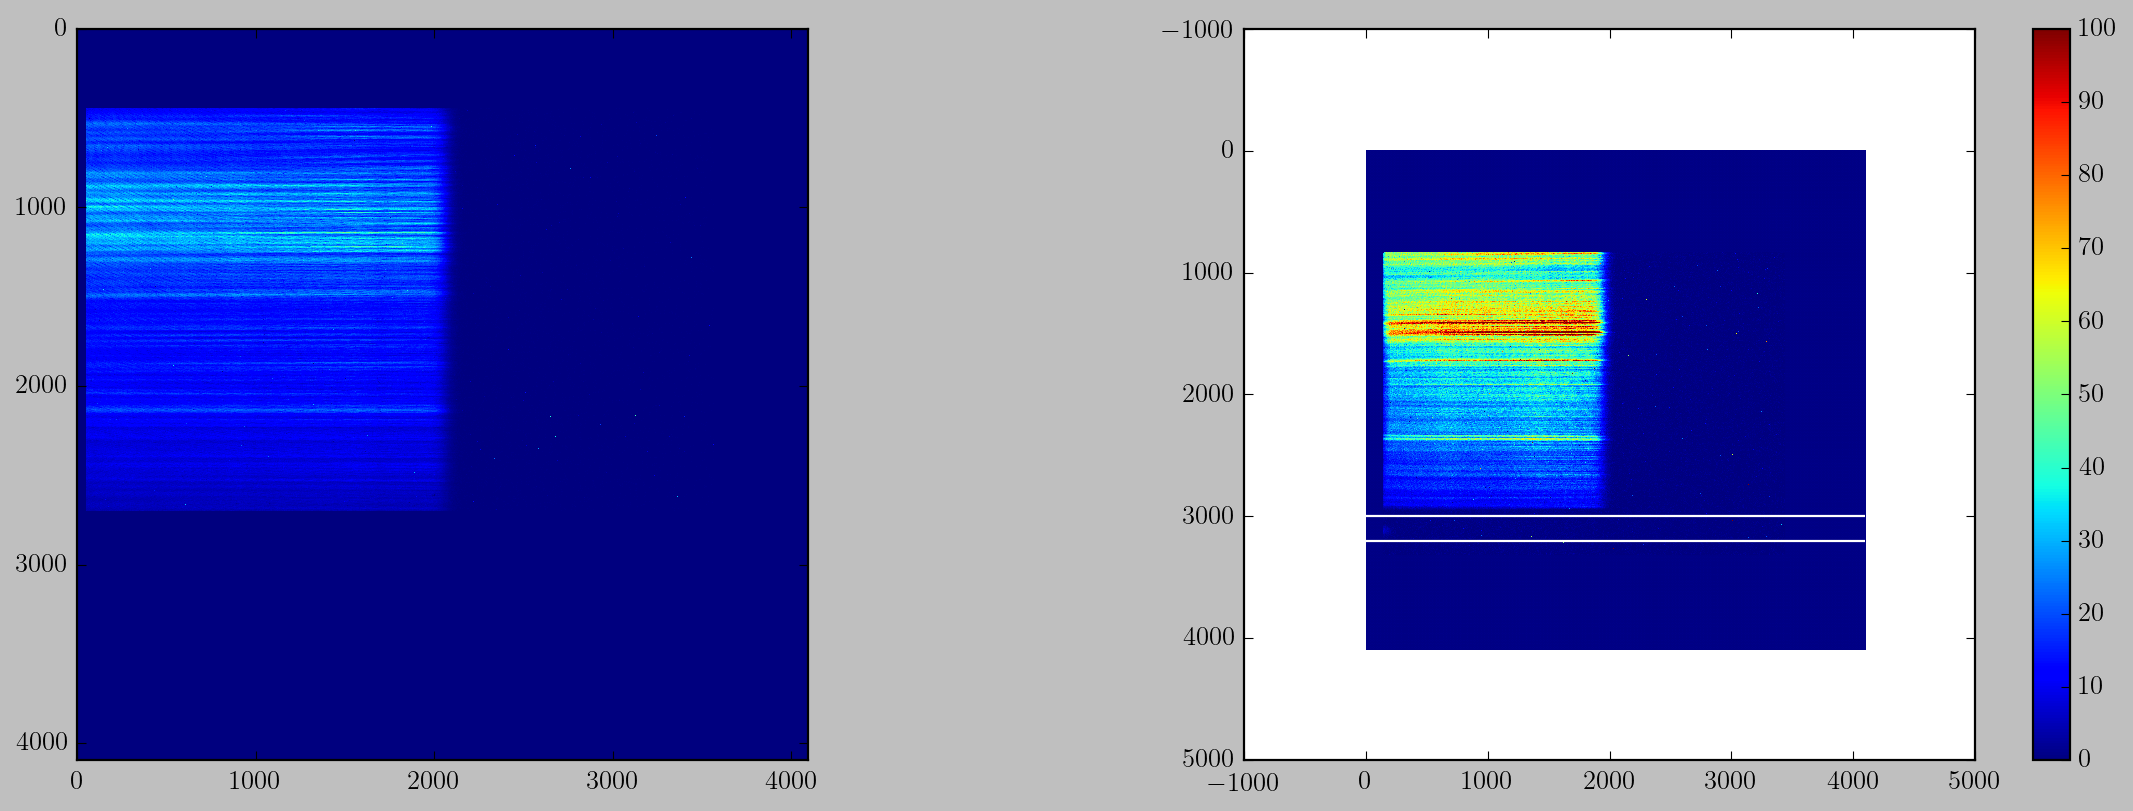

In [10]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_r-imgKEP1_bckg, vmin = 0, vmax = 500, cmap = plt.cm.jet)

plt.subplot(222)
plt.imshow(imgKEP2_r-imgKEP2_bckg, vmin = 0, vmax = 100, cmap = plt.cm.jet)
plt.hlines(3000, 0, 4095, color = 'w')
plt.hlines(3200, 0, 4095, color = 'w')
plt.colorbar()
plt.tight_layout()
plt.show()

### The output of the cell below should be used in the .toml file for the pixDipole_0ns.XXns variable in KEPLER 1 section. XX would the duration of the sweep window. In this case, 10 ns. It is important that the sweep window delay is 0 ns. 

In [11]:


lineoutFiducial_bckg_KEPLER1 = np.mean(imgKEP1_r[1000:2500, 500:3500], axis = 0)
lineoutFiducial_filter_bckg_KEPLER1 = gaussian_filter(lineoutFiducial_bckg_KEPLER1, 5)
lineoutFiducial_filter_1stDeriv_bckg_KEPLER1 = np.diff(lineoutFiducial_filter_bckg_KEPLER1)

positionRightEdgeFiducial_KEPLER1 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)
positionLeftEdgeFiducial_KEPLER1 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)

print(4096 - (500 + positionRightEdgeFiducial_KEPLER1)) # Because time goes right to left and we want time left to right for VISAR analysis so need to do 4096 - val

2045


### The output of the cell below should be used in the .toml file for the pixDipole_0ns.XXns variable in KEPLER 2 section. XX would the duration of the sweep window. In this case, 10 ns. It is important that the sweep window delay is 0 ns. 

In [12]:
lineoutFiducial_bckg_KEPLER2 = np.mean(imgKEP2_r[1000:2500, 500:3000], axis = 0)
lineoutFiducial_filter_bckg_KEPLER2 = gaussian_filter(lineoutFiducial_bckg_KEPLER2, 5)
lineoutFiducial_filter_1stDeriv_bckg_KEPLER2 = np.diff(lineoutFiducial_filter_bckg_KEPLER2)

positionRightEdgeFiducial_KEPLER2 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)
positionLeftEdgeFiducial_KEPLER2 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)

print(4096 - (500 + positionRightEdgeFiducial_KEPLER2))

2169


### The output of the cell below should be used in the .toml file for the positionTrigger_ref.XX ns. XX would the duration of the sweep window. In this case, 10 ns. It is important that the sweep window delay is 0ns. This corresponds to the trigger of the streak camera for a 0 ns sweep delay. The first value corresponds to KEPLER1, the second to KEPLER2, the third to VISAR_1w in the '.toml' file. 

In [ ]:
run = ed.open_run(proposalNumber, runNumber)
print(run['HED_EXP_VISAR/TSYS/ARM_1_TRIG', 'actualPosition'].ndarray()[0])
print(run['HED_EXP_VISAR/TSYS/ARM_2_TRIG', 'actualPosition'].ndarray()[0])
print(run['HED_EXP_VISAR/TSYS/ARM_3_TRIG', 'actualPosition.value'].ndarray()[0])


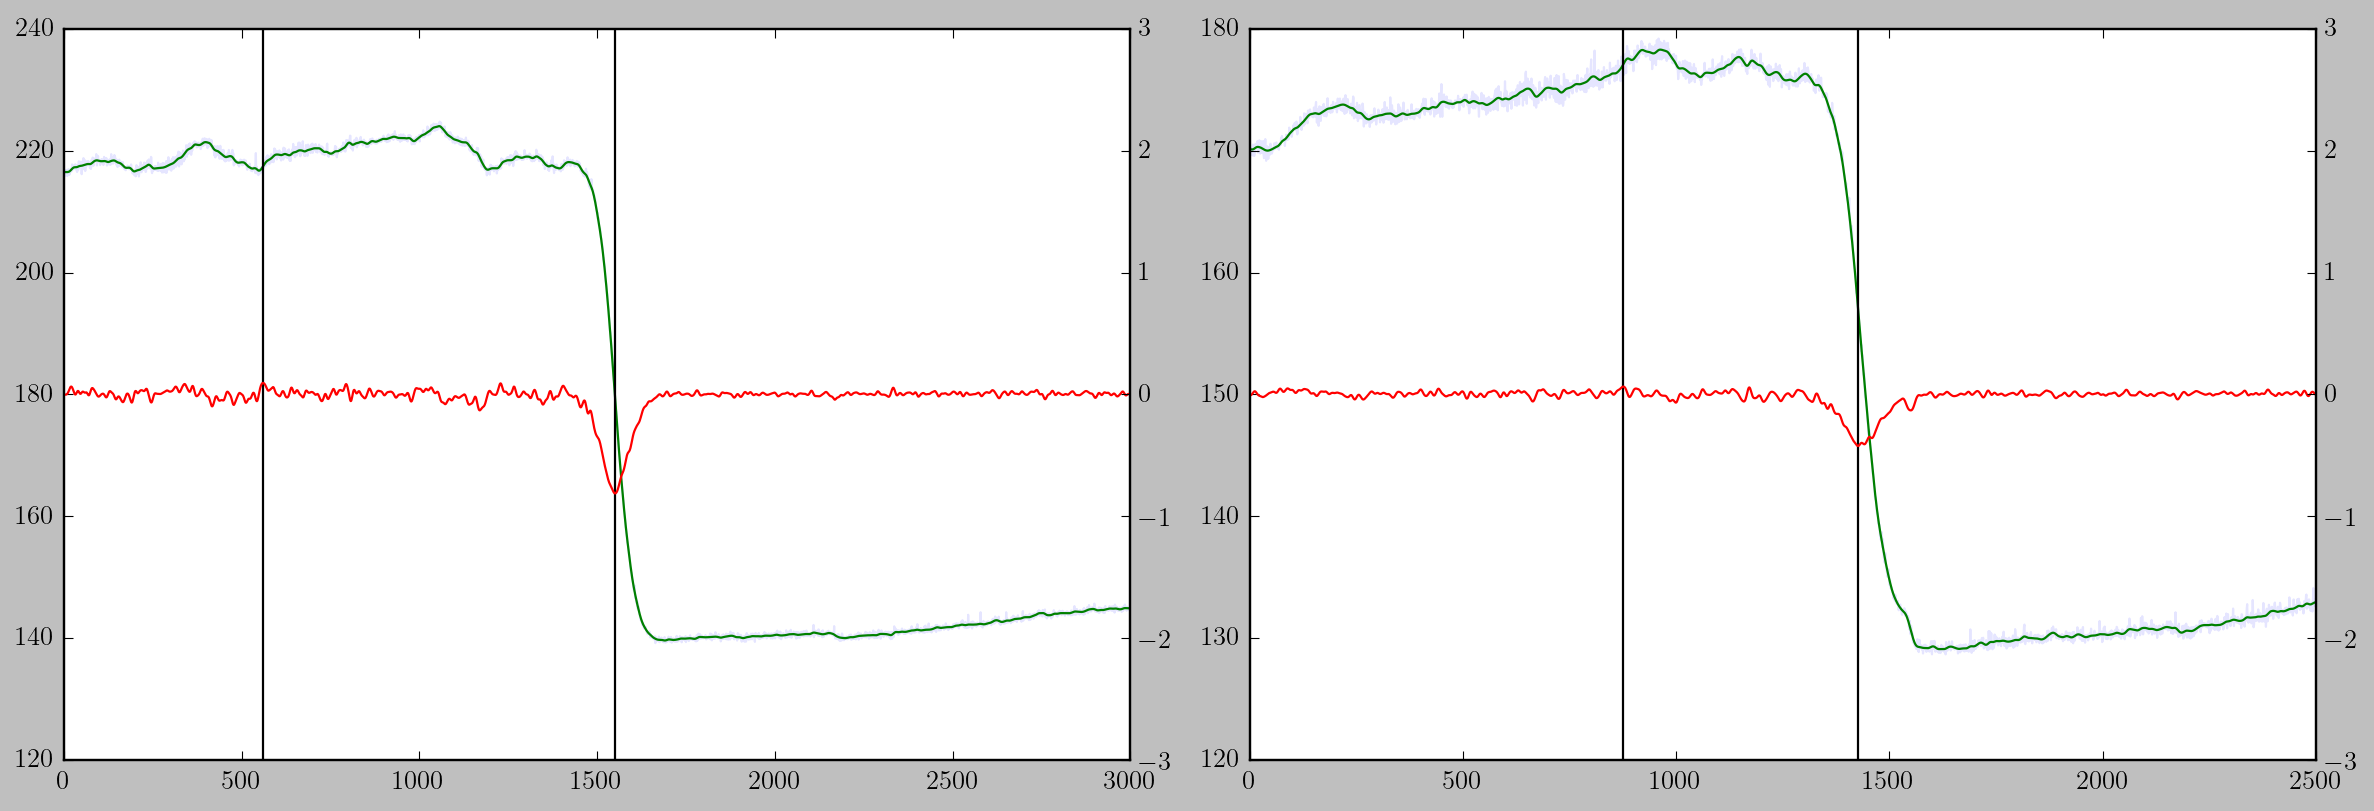

In [13]:
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(221)
plt.plot(lineoutFiducial_bckg_KEPLER1, alpha = 0.1)
plt.plot(lineoutFiducial_filter_bckg_KEPLER1)

ax2 = ax1.twinx()
ax2.plot(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1, 'C2')
plt.vlines(positionLeftEdgeFiducial_KEPLER1, -3, 3)
plt.vlines(positionRightEdgeFiducial_KEPLER1, -3, 3)

ax3 = plt.subplot(222)
plt.plot(lineoutFiducial_bckg_KEPLER2, alpha = 0.1)
plt.plot(lineoutFiducial_filter_bckg_KEPLER2)

ax4 = ax3.twinx()
ax4.plot(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2, 'C2')
plt.vlines(positionLeftEdgeFiducial_KEPLER2, -3, 3)
plt.vlines(positionRightEdgeFiducial_KEPLER2, -3, 3)
plt.tight_layout()
plt.show()

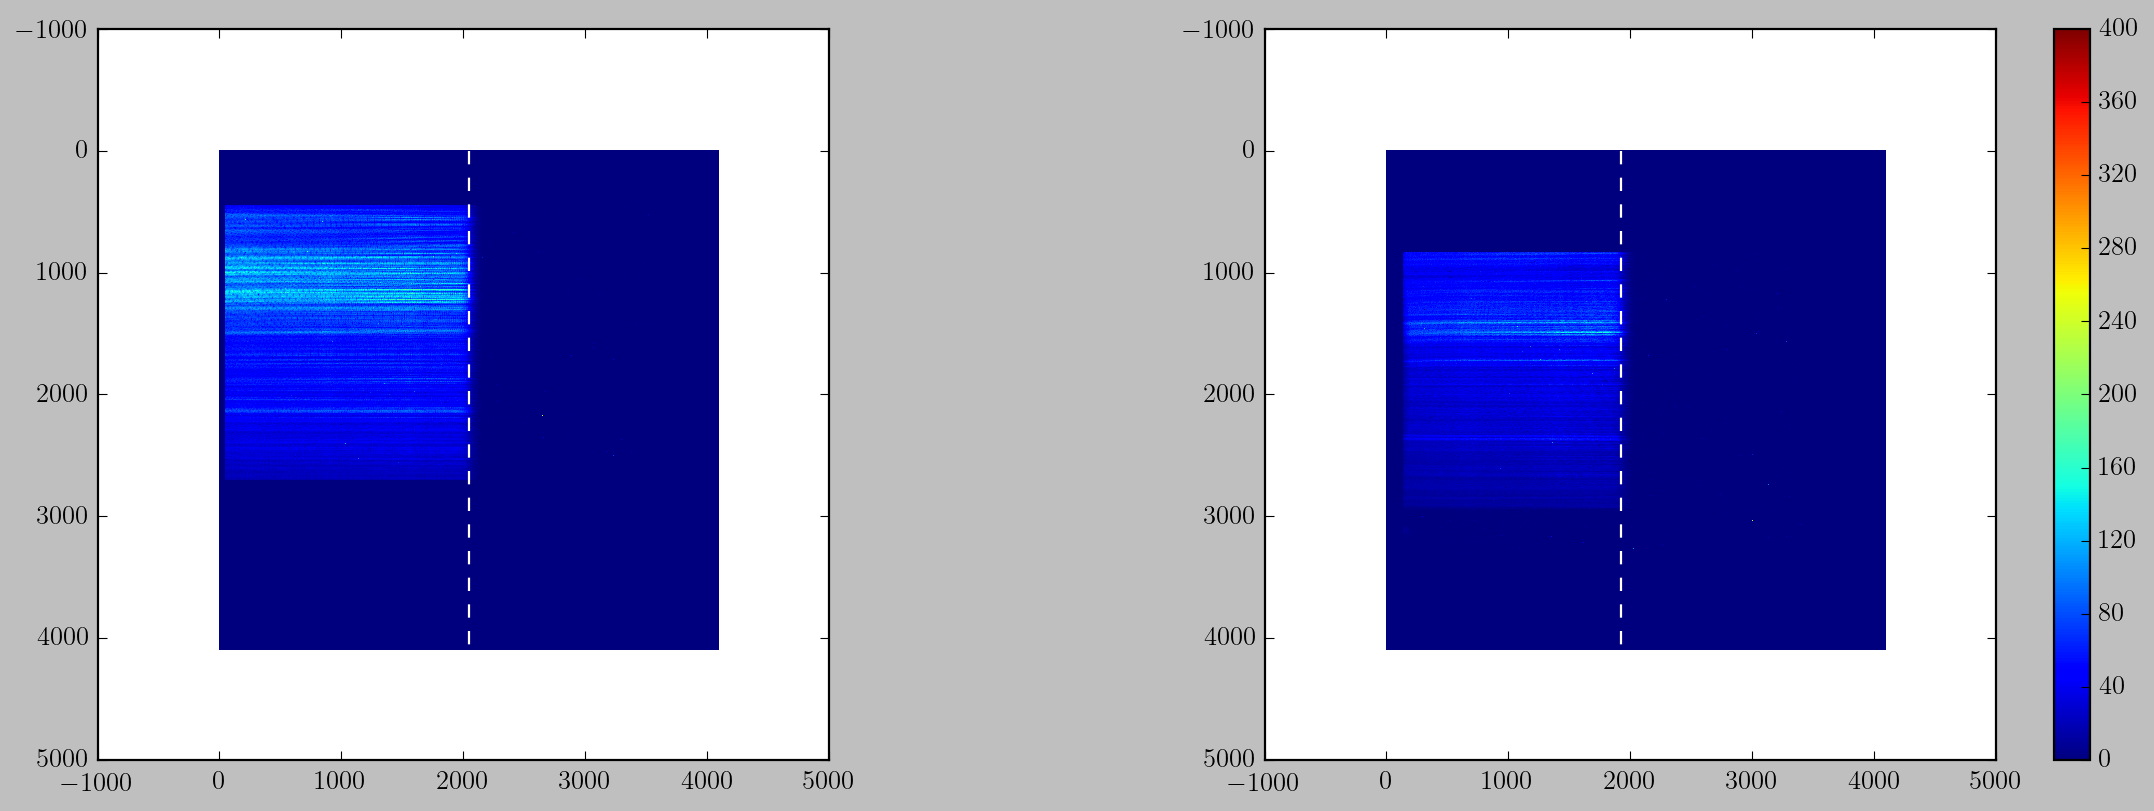

In [14]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_r-imgKEP1_bckg, vmin = 0, vmax = 500, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(500 + positionRightEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')

plt.subplot(222)
plt.imshow(imgKEP2_r-imgKEP2_bckg, vmin = 0, vmax = 400, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER2, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(500 + positionRightEdgeFiducial_KEPLER2, 0, 4095, linestyles='dashed', colors = 'w')
plt.colorbar()
plt.tight_layout()
plt.show()

## Extract the position of the rising edges for a list of run to get the dispersion axis ns/pix

In [15]:
imgKEP1_DelayScan = []
imgKEP2_DelayScan = []

imgKEP1_RightEdgePosition_DelayScan = []
imgKEP2_RightEdgePosition_DelayScan = []

for i in range(648, 650):
    print(i)
    imgKEP1_r, imgKEP2_r  = extraVISARImages_mean(2740, i)
    imgKEP1_DelayScan += [imgKEP1_r]
    imgKEP2_DelayScan += [imgKEP2_r]
    
    ## KEPLER1
    lineoutFiducial_bckg_KEPLER1 = np.mean(imgKEP1_r[1000:2500, 500:3500], axis = 0)
    lineoutFiducial_filter_bckg_KEPLER1 = gaussian_filter(lineoutFiducial_bckg_KEPLER1, 5)
    lineoutFiducial_filter_1stDeriv_bckg_KEPLER1 = np.diff(lineoutFiducial_filter_bckg_KEPLER1)

    positionRightEdgeFiducial_KEPLER1 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)
    imgKEP1_RightEdgePosition_DelayScan += [500 + positionRightEdgeFiducial_KEPLER1]
    positionLeftEdgeFiducial_KEPLER1 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)
    
    ## KEPLER2  
    lineoutFiducial_bckg_KEPLER2 = np.mean(imgKEP2_r[1000:2500, 500:3000], axis = 0)
    lineoutFiducial_filter_bckg_KEPLER2 = gaussian_filter(lineoutFiducial_bckg_KEPLER2, 5)
    lineoutFiducial_filter_1stDeriv_bckg_KEPLER2 = np.diff(lineoutFiducial_filter_bckg_KEPLER2)

    positionRightEdgeFiducial_KEPLER2 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)
    imgKEP2_RightEdgePosition_DelayScan += [500 + positionRightEdgeFiducial_KEPLER2]
    positionLeftEdgeFiducial_KEPLER2 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)
    
    
    

imgKEP1_DelayScan = np.array(imgKEP1_DelayScan)
imgKEP1_RightEdgePosition_DelayScan = np.array(imgKEP1_RightEdgePosition_DelayScan)

imgKEP2_DelayScan = np.array(imgKEP2_DelayScan)
imgKEP2_RightEdgePosition_DelayScan = np.array(imgKEP2_RightEdgePosition_DelayScan)

648
649


In [16]:
imgKEP2_RightEdgePosition_DelayScan

array([1927, 2676])

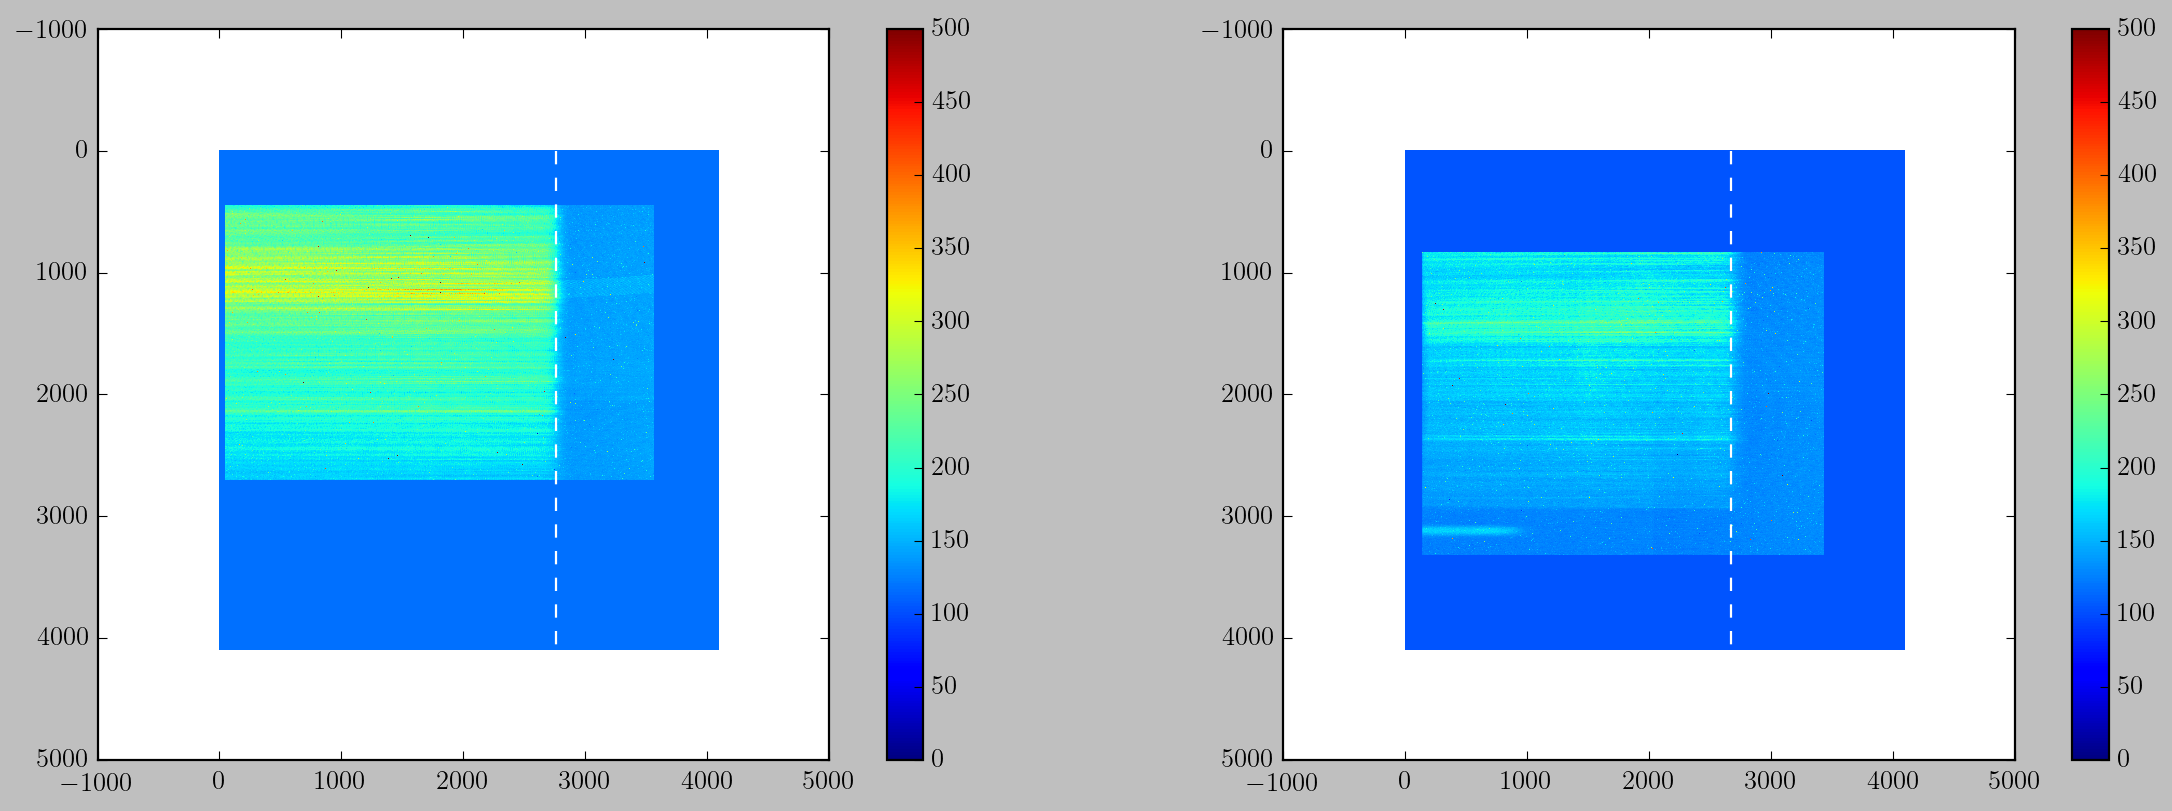

In [17]:
idx = 1
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_DelayScan[idx], vmin = 0, vmax = 500, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(imgKEP1_RightEdgePosition_DelayScan[idx], 0, 4095, linestyles='dashed', colors = 'w')
plt.colorbar()

plt.subplot(222)
plt.imshow(imgKEP2_DelayScan[idx], vmin = 0, vmax = 500, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(imgKEP2_RightEdgePosition_DelayScan[idx], 0, 4095, linestyles='dashed', colors = 'w')
plt.colorbar()

plt.tight_layout()
plt.show()

In [18]:
timeDelayDipole = [0, -2]
poptDipole_KEPLER1 = np.polyfit(imgKEP1_RightEdgePosition_DelayScan, timeDelayDipole, 1)
poptDipole_KEPLER2 = np.polyfit(imgKEP2_RightEdgePosition_DelayScan, timeDelayDipole, 1)


In [29]:
poptDipole_KEPLER1, poptDipole_KEPLER2

(array([-2.81293952e-03,  5.76933896e+00]),
 array([-2.67022697e-03,  5.14552737e+00]))

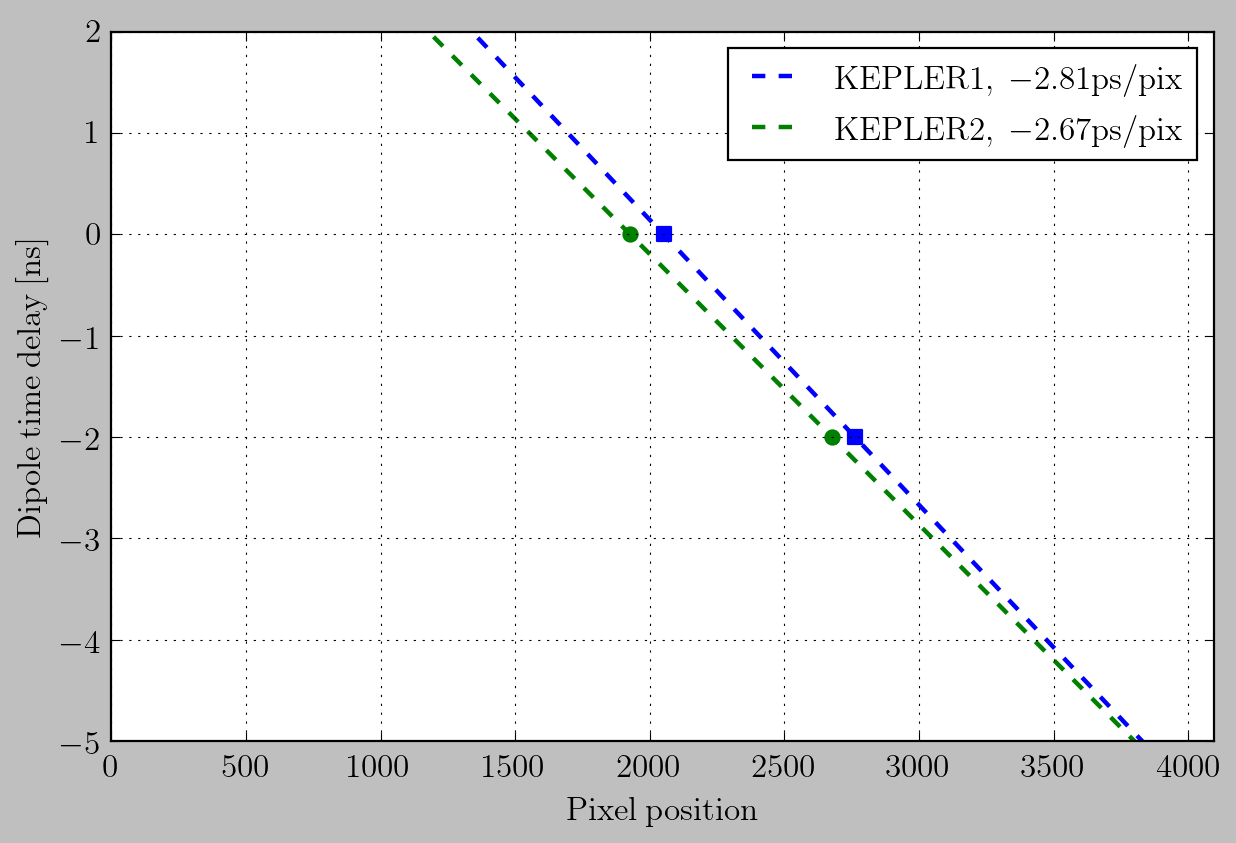

In [20]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.scatter(imgKEP1_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C0', marker = 's', s = 40)
plt.scatter(imgKEP2_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C1', marker = 'o', s = 40)

plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER1[0] + poptDipole_KEPLER1[1], '--C0', lw  =2, label = '$\\rm{KEPLER1, \\: %.2f ps/pix}$'%(poptDipole_KEPLER1[0]*1000))
plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER2[0] + poptDipole_KEPLER2[1], '--C1', lw  =2, label = '$\\rm{KEPLER2, \\: %.2f ps/pix}$'%(poptDipole_KEPLER2[0]*1000))

plt.grid()
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim([0, 4096])
plt.ylim([-5, 2])
plt.xlabel('$\\rm{Pixel \\: position}$', fontsize = 15)
plt.ylabel('$\\rm{Dipole \\: time \\: delay \\: [ns]}$', fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

## Timing Diple Fiducial

In [23]:
dipoleFiducial = np.mean((imgKEP2_r-imgKEP2_bckg)[3050:3100, 200:], axis = 0)
lineoutFiducial_dipoleFiducial = gaussian_filter(dipoleFiducial, 20)
lineoutFiducial_dipoleFiducial_1stDeriv = np.diff(lineoutFiducial_dipoleFiducial)

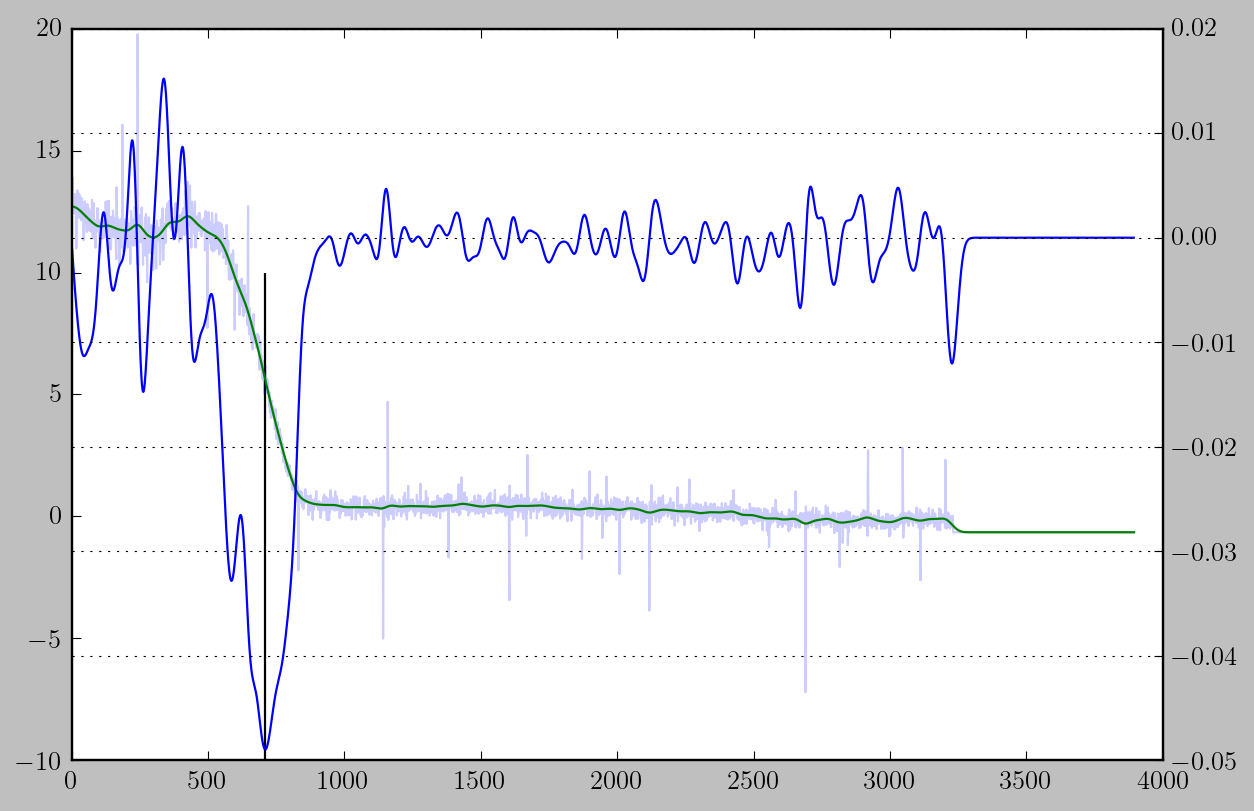

In [24]:
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(221)
plt.plot(dipoleFiducial, alpha = 0.2)
plt.plot(lineoutFiducial_dipoleFiducial)
plt.vlines(np.argmin(lineoutFiducial_dipoleFiducial_1stDeriv), -10, 10)
ax2 = ax1.twinx()
plt.plot(lineoutFiducial_dipoleFiducial_1stDeriv)

# plt.imshow((imgKEP2_r-imgKEP2_bckg)[3050:3100, :])
plt.grid()
plt.tight_layout()
plt.show()

In [25]:
np.argmin(lineoutFiducial_dipoleFiducial_1stDeriv)

710

In [26]:


imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan = []


for i in range(650, 652):
    print(i)
    imgKEP1_r, imgKEP2_r  = extraVISARImages_mean(2740, i)

    ## KEPLER2  
    dipoleFiducial = np.mean((imgKEP2_r-imgKEP2_bckg)[3050:3100, :], axis = 0)
    lineoutFiducial_dipoleFiducial = gaussian_filter(dipoleFiducial, 10)
    lineoutFiducial_dipoleFiducial_1stDeriv = np.diff(lineoutFiducial_dipoleFiducial)

    positionRightEdgeDipoleFiducial_KEPLER2 = np.argmin(lineoutFiducial_dipoleFiducial_1stDeriv)
    imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan += [positionRightEdgeDipoleFiducial_KEPLER2]

650
651


In [27]:
imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan

[1741, 2444]

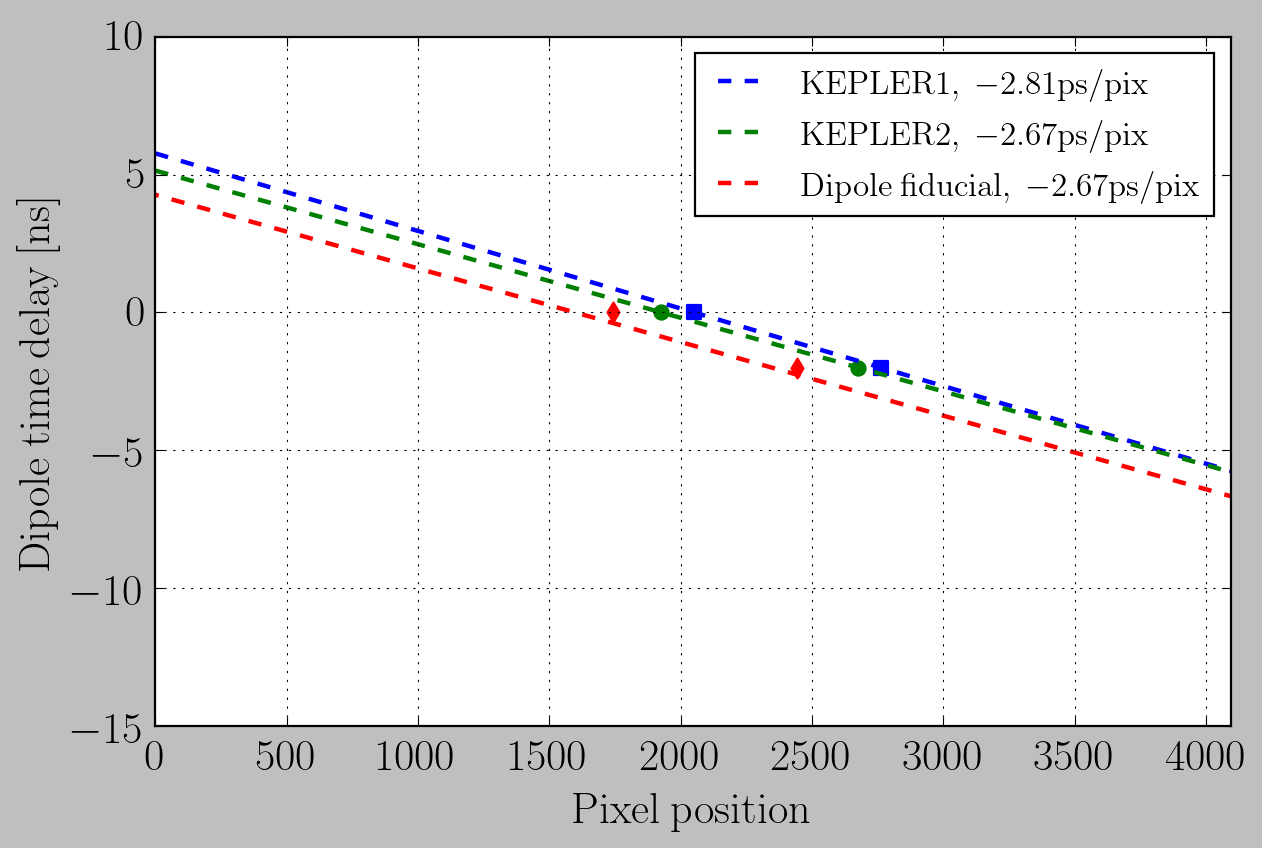

In [28]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.scatter(imgKEP1_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C0', marker = 's', s = 40)
plt.scatter(imgKEP2_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C1', marker = 'o', s = 40)
plt.scatter(imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan, timeDelayDipole, color = 'C2', marker = 'd', s = 40)

plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER1[0] + poptDipole_KEPLER1[1], '--C0', lw  =2, label = '$\\rm{KEPLER1, \\: %.2f ps/pix}$'%(poptDipole_KEPLER1[0]*1000))
plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER2[0] + poptDipole_KEPLER2[1], '--C1', lw  =2, label = '$\\rm{KEPLER2, \\: %.2f ps/pix}$'%(poptDipole_KEPLER2[0]*1000))

plt.plot(np.arange(0, 4500, 10)-329, np.arange(0, 4500, 10)*poptDipole_KEPLER2[0] + poptDipole_KEPLER2[1], '--C2', lw  =2, label = '$\\rm{Dipole \\:fiducial, \\: %.2f ps/pix}$'%(poptDipole_KEPLER2[0]*1000))


plt.grid()
plt.legend(fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim([0, 4096])
plt.ylim([-15, 10])
plt.xlabel('$\\rm{Pixel \\: position}$', fontsize = 20)
plt.ylabel('$\\rm{Dipole \\: time \\: delay \\: [ns]}$', fontsize = 20)

plt.tight_layout()
# plt.savefig('./CalibrationTimingDipole.png', dpi = 300)
plt.show()

## The section below is used for the VISAR_1w 

In [16]:
run = ed.open_run(proposalNumber, runNumber)
VISAR1w = run['HED_EXP_VISAR/EXP/ARM_3_STREAK:daqOutput', 'data.image.pixels'].ndarray()
VISAR1w = np.mean(VISAR1w, axis = 0)
VISAR1w_corrected = np.flipud(cv2.rotate(cv2.resize(VISAR1w,
                                                 (VISAR1w.shape[0]*2, VISAR1w.shape[1]*2),
                                                  interpolation=cv2.INTER_CUBIC),
                                                  cv2.ROTATE_90_COUNTERCLOCKWISE))

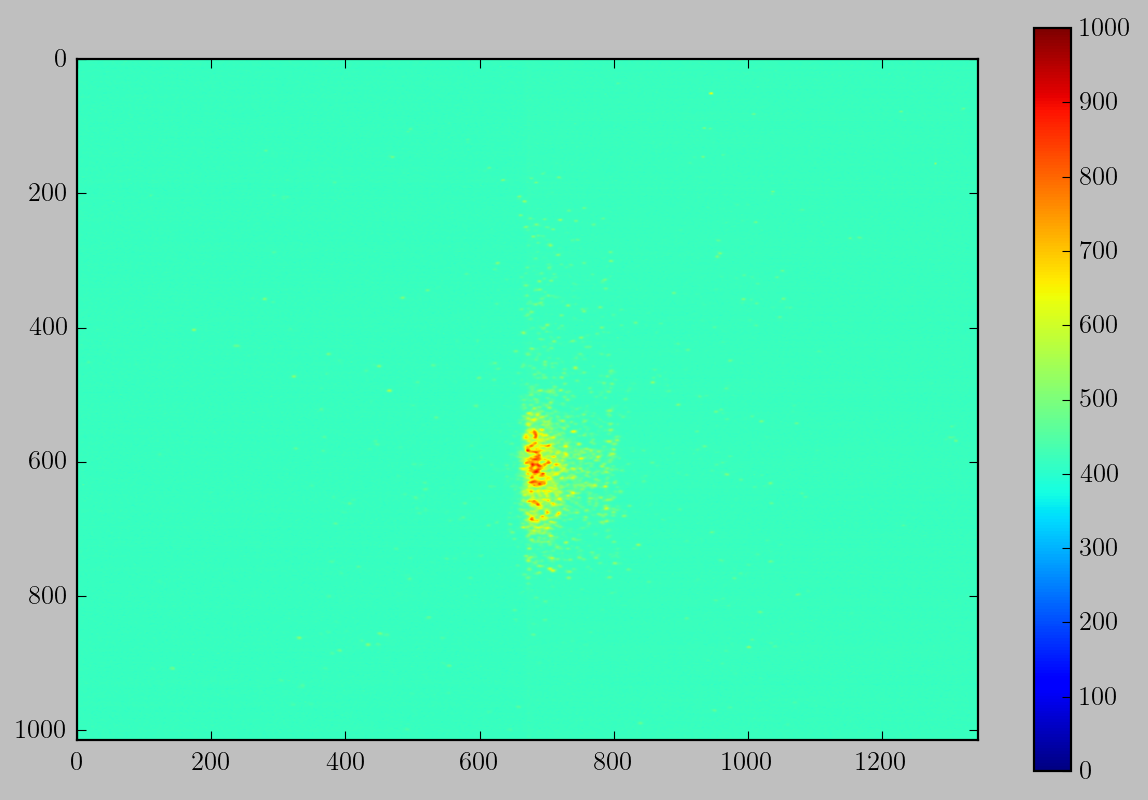

In [17]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(VISAR1w_corrected, vmin = 0, vmax = 1000, cmap = plt.cm.jet)

plt.colorbar()
plt.tight_layout()
plt.show()

### The output of the cell below should be used in the .toml file for the pixDipole_0ns.XXns variable in VISAR_1w section. XX would the duration of the sweep window. In this case 50 ns. It is important that the sweep window delay is 0 ns. 

In [18]:
lineoutFiducial_bckg_VISAR1w = np.mean(VISAR1w_corrected[500:800, :], axis = 0)
lineoutFiducial_filter_bckg_VISAR1w = gaussian_filter(lineoutFiducial_bckg_VISAR1w, 5)
lineoutFiducial_filter_1stDeriv_bckg_VISAR1w = np.diff(lineoutFiducial_filter_bckg_VISAR1w)

positionRightEdgeFiducial_VISAR1w = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_VISAR1w)
positionLeftEdgeFiducial_VISAR1w = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_VISAR1w)

print(positionLeftEdgeFiducial_VISAR1w)
# print(4096 - (500 + positionRightEdgeFiducial_KEPLER1)) # Because time goes right to left and we want time left to right for VISAR analysis so need to do 4096 - val

668


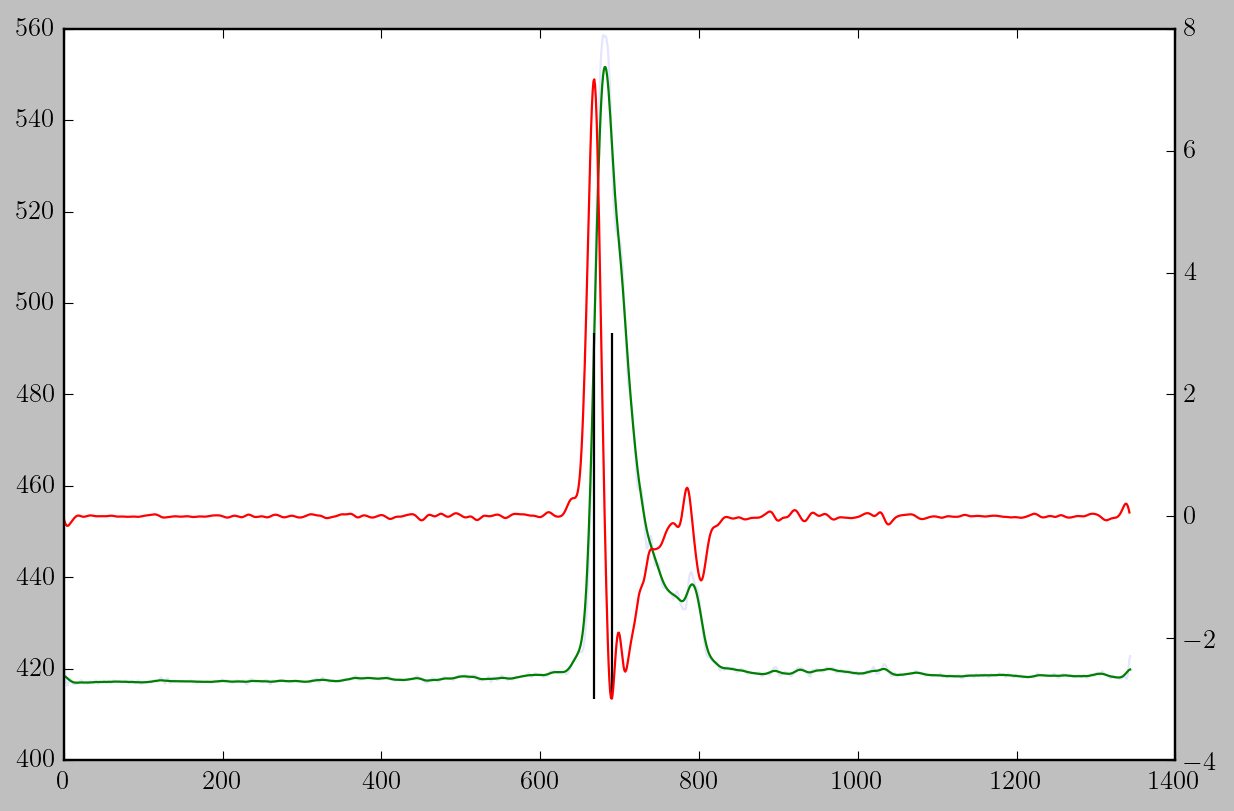

In [19]:
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(221)
plt.plot(lineoutFiducial_bckg_VISAR1w, alpha = 0.1)
plt.plot(lineoutFiducial_filter_bckg_VISAR1w)

ax2 = ax1.twinx()
ax2.plot(lineoutFiducial_filter_1stDeriv_bckg_VISAR1w, 'C2')
plt.vlines(positionRightEdgeFiducial_VISAR1w, -3, 3)
plt.vlines(positionLeftEdgeFiducial_VISAR1w, -3, 3)

plt.tight_layout()
plt.show()

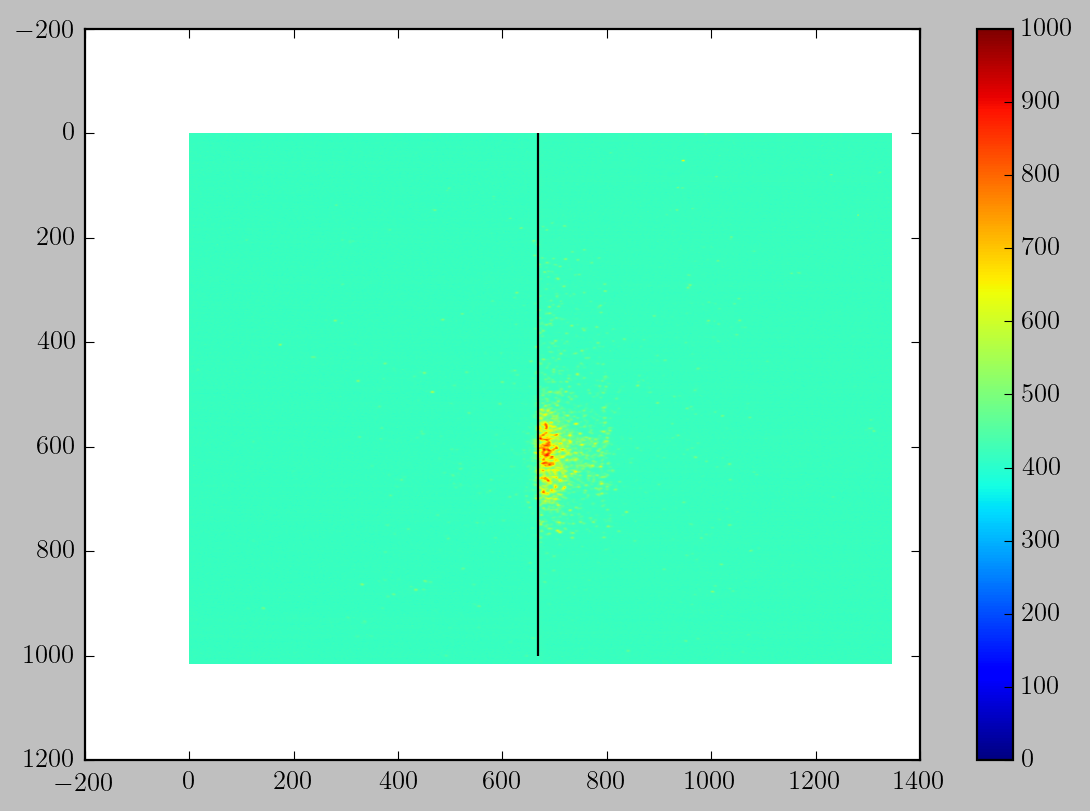

In [20]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(VISAR1w_corrected, vmin = 0, vmax = 1000, cmap = plt.cm.jet)
plt.vlines(positionLeftEdgeFiducial_VISAR1w, 0, 1000)
plt.colorbar()
plt.tight_layout()
plt.show()